In [1]:
from typing import Tuple
import math

In [2]:
def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    """Returns mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

P(both | older): 0.5007089325501317
P(both | either): 0.3311897106109325


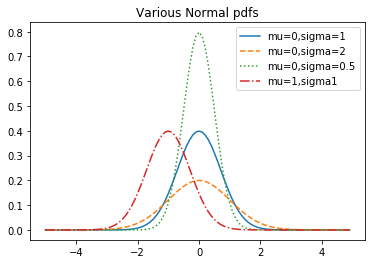

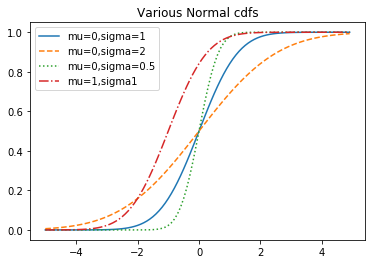

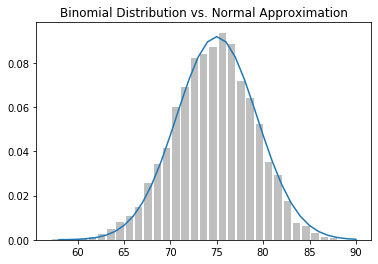

In [3]:
%run chapter6-probability.ipynb

In [4]:
# The normal_cdf _is_ the probability the variable below a threshold
normal_probability_below = normal_cdf

# It's above the threshold if it's not below the threshold
def normal_probability_above(lo: float, mu: float = 0, sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is greater than lo."""
    return 1 - normal_cdf(lo, mu, sigma)

# It's between if it's less than hi, but not less than lo
def normal_probability_between(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is between lo and hi."""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# It's outside if it's not between
def normal_probability_outside(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is not between lo and hi."""
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [5]:
# Reverse
def normal_upper_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float, mu: float = 0, sigma: float = 1) -> float:
    tail_probability = (1 - probability) / 2
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

In [7]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


In [8]:
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)

In [9]:
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability

In [10]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability

In [11]:
# p-Value
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """
    How likely are we to see a value at least as extreme as x (in either direction)
    if our values are from an N(mu, sigma)?
    """
    if x >= mu:
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        return 2 * normal_probability_below(x, mu, sigma)

In [12]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598835

In [14]:
import random

extreme_value_count = 0
for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0
                    for _ in range(1000))
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1
    
assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

In [15]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [16]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [17]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

In [18]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

In [20]:
# Confidence Intervals
#math.sqrt(p * (1 - p) / 1000)

In [22]:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 100)
print(mu, sigma)

0.525 0.04993746088859544


In [23]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.42712443209227113, 0.6228755679077289)

In [24]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
normal_two_sided_bounds(0.95, mu, sigma)

(0.5091095927295919, 0.5708904072704082)

In [29]:
from typing import List

def run_experiment() -> List[bool]:
    """Flips a fair coin 1000 times, True = heads, False = tails."""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment: List[bool]) -> bool:
    """Using 5% significanve levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment 
                      for experiment in experiments
                      if reject_fairness(experiment)])

assert num_rejections == 46

In [30]:
# Running an A/B Test
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [31]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [32]:
z = a_b_test_statistic(1000, 200, 1000, 180); z

-1.1403464899034472

In [33]:
two_sided_p_value(z)

0.2541419765422359

In [34]:
z = a_b_test_statistic(1000, 200, 1000, 150); z

-2.948839123097944

In [35]:
two_sided_p_value(z)

0.003189699706216853

In [36]:
def B(alpha: float, beta: float) -> float:
    """A normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta -1) / B(alpha, beta)